In [2]:
import gpytorch
import UncertainKernel
import UncertainMeanZero
import math
import torch
from matplotlib import pyplot as plt

In [3]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x_mean = torch.linspace(0, 1, 20)
# We'll assume the variance shrinks the closer we get to 1
train_x_stdv = torch.linspace(0.03, 0.01, 20)
inputsZipped = torch.tensor(list(zip(train_x_mean, train_x_stdv)))

# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x_mean * (2 * math.pi)) + torch.randn(train_x_mean.size()) * 0.2

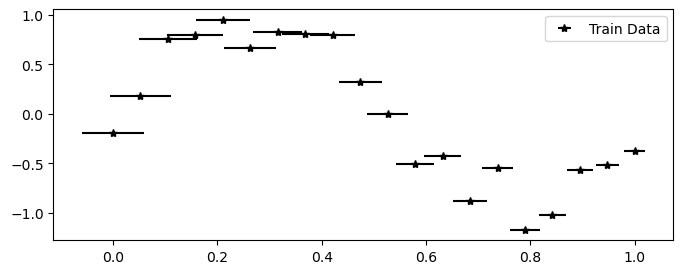

In [4]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.errorbar(train_x_mean, train_y, xerr=(train_x_stdv * 2), fmt="k*", label="Train Data")
ax.legend()

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = UncertainMeanZero.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(UncertainKernel.UncertainKernel())


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [6]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(inputsZipped, train_y, likelihood)

In [7]:
training_iter = 500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(inputsZipped)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/500 - Loss: 1.034   lengthscale: 0.693   noise: 0.693
Iter 2/500 - Loss: 1.008   lengthscale: 0.644   noise: 0.644
Iter 3/500 - Loss: 0.981   lengthscale: 0.598   noise: 0.598
Iter 4/500 - Loss: 0.953   lengthscale: 0.554   noise: 0.554
Iter 5/500 - Loss: 0.925   lengthscale: 0.513   noise: 0.513
Iter 6/500 - Loss: 0.895   lengthscale: 0.473   noise: 0.474
Iter 7/500 - Loss: 0.864   lengthscale: 0.436   noise: 0.438
Iter 8/500 - Loss: 0.830   lengthscale: 0.402   noise: 0.403
Iter 9/500 - Loss: 0.794   lengthscale: 0.369   noise: 0.371
Iter 10/500 - Loss: 0.756   lengthscale: 0.338   noise: 0.341
Iter 11/500 - Loss: 0.716   lengthscale: 0.309   noise: 0.313
Iter 12/500 - Loss: 0.677   lengthscale: 0.283   noise: 0.286
Iter 13/500 - Loss: 0.641   lengthscale: 0.258   noise: 0.262
Iter 14/500 - Loss: 0.609   lengthscale: 0.236   noise: 0.239
Iter 15/500 - Loss: 0.580   lengthscale: 0.217   noise: 0.218
Iter 16/500 - Loss: 0.553   lengthscale: 0.202   noise: 0.198
Iter 17/500 - Los

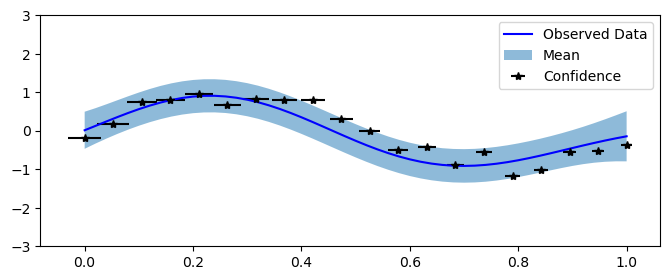

In [8]:
model.eval()
likelihood.eval()

# Please Note: testing data size needs to be same as training to ensure combined matrix is correct size
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.lazily_evaluate_kernels(False):
    test_x = torch.linspace(0, 1, 51)
    test_x_distributional = torch.stack((test_x, (0 * torch.ones_like(test_x))), dim=1)
    observed_pred = likelihood(model(test_x_distributional))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_x_mean.numpy(), train_y.numpy(), xerr=train_x_stdv, fmt='k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [9]:
test_y = torch.sin(test_x * (2 * math.pi))

In [10]:
torch.mean(torch.abs(test_y - observed_pred.mean))

tensor(0.1259)